# Packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression

# Data

In [2]:
train = pd.read_csv("train.csv")

# Modeling

In [3]:
# training set과 test set 지정

Train = train.iloc[:,:-1] 
Test = train.iloc[:,-1]
x_train,x_test,y_train,y_test = train_test_split(Train,Test, test_size=0.2,random_state=42)

x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X = x_train
y = y_train 

## Hyperparameter tuning

In [4]:
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr, n_jobs=-1, n_iter=nbr_iter, cv=5, random_state=0)
    #CV = Cross-Validation ( here using Stratified KFold CV)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

def hypertuning_gscv(est, p_distr,X,y):
    gdsearch = GridSearchCV(est, param_grid=p_distr, n_jobs=-1, cv=5)
    gdsearch.fit(X,y)
    bt_param = gdsearch.best_params_
    bt_score = gdsearch.best_score_    
    return bt_param, bt_score

In [5]:
dt_params = {"criterion": ["gini", "entropy"],
              "min_samples_split": randint(2, 20),
              "max_depth": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "max_leaf_nodes": randint(2, 20)}

rf_params = {'max_depth':np.arange(3, 30), 
            'n_estimators':np.arange(100, 400),
            'min_samples_split':np.arange(2, 10)}

lgbm_params ={'max_depth': np.arange(3, 30),
             'num_leaves': np.arange(10, 100), 
             'learning_rate': [ 0.01, 0.05, 0.01, 0.001],
             'min_child_samples': randint(2, 30),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': np.linspace(0.6, 0.9, 30, endpoint=True), 
             'colsample_bytree': np.linspace(0.1, 0.8, 100, endpoint=True),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'n_estimators': np.arange(100, 400)}


params_list = [dt_params, rf_params, lgbm_params]

In [6]:
names = ['DecisionTree', 'RandomForest', 'LGBM']
clf_list = [DecisionTreeClassifier(random_state=10), RandomForestClassifier(random_state=10), lgb.LGBMClassifier(random_state=10)]

best_param_dict = dict()
print('5-fold cross validation scores & best parameters :\n')
for name, clf, param_list in zip(names, clf_list, params_list):
    print('---- {} with RandomSearch ----'.format(name))
    
    best_params = hypertuning_rscv(clf, param_list, 30, X.iloc[:,1:], y)
    best_param_dict[name] = best_params[0]
    print('best_params : ', best_params[0])
    
    clf.set_params(**best_params[0])
    cv_score = cross_val_score(clf, X.iloc[:,1:], y, cv=5).mean()
    print('cv score : ', cv_score)
    clf.fit(X.iloc[:,1:], y)
    clf_pred = clf.predict(x_test.iloc[:,1:])
    print("accuracy: {0:.4f}".format(accuracy_score(clf_pred, y_test)))

5-fold cross validation scores & best parameters :

---- DecisionTree with RandomSearch ----
best_params :  {'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 17, 'min_samples_leaf': 5, 'min_samples_split': 11}
cv score :  0.6474042275511703
accuracy: 0.6425
---- RandomForest with RandomSearch ----
best_params :  {'n_estimators': 391, 'min_samples_split': 2, 'max_depth': 22}
cv score :  0.8477186119528936
accuracy: 0.8674
---- LGBM with RandomSearch ----
best_params :  {'colsample_bytree': 0.4747474747474748, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_samples': 10, 'min_child_weight': 1, 'n_estimators': 373, 'num_leaves': 89, 'reg_alpha': 5, 'reg_lambda': 0.1, 'subsample': 0.7034482758620689}
cv score :  0.8298611884564006
accuracy: 0.8439


# Voting 알고리즘의 이해

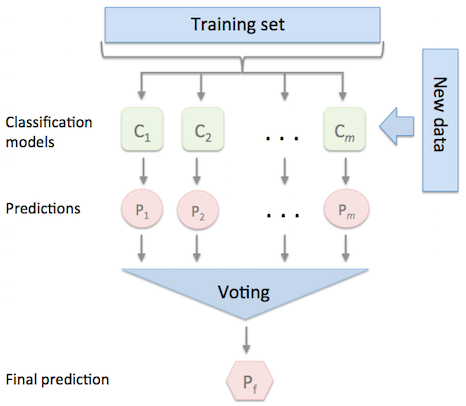

- Hard Voting의 경우에는 Prediction이 label값으로 나온다.

- Soft Voting의 경우에는 Prediction이 probability값으로 나온다.

In [7]:
x_test2 = x_test.copy()

In [8]:
# 1. DecisionTree의 predicted proba
dt_bst = DecisionTreeClassifier(**best_param_dict['DecisionTree'], random_state=10)
dt_bst.fit(X.iloc[:,1:],y)
dt_proba = dt_bst.predict_proba(x_test.iloc[:,1:])
dt_result = dt_bst.predict(x_test.iloc[:,1:])

# 2. RF의 predicted_proba
rf_bst = RandomForestClassifier(**best_param_dict['RandomForest'], random_state=10)
rf_bst.fit(X.iloc[:,1:],y)
rf_proba = rf_bst.predict_proba(x_test.iloc[:,1:])
rf_result = rf_bst.predict(x_test.iloc[:,1:])

# 3. LGB의 predicted_proba
lgb_bst = lgb.LGBMClassifier(**best_param_dict['LGBM'], random_state=10)
lgb_bst.fit(X.iloc[:,1:],y)
lgb_proba = lgb_bst.predict_proba(x_test.iloc[:,1:])
lgb_result = lgb_bst.predict(x_test.iloc[:,1:])

## Hard Voting

In [9]:
names = ['dt_result','rf_result','lgb_result']
res_data = [dt_result, rf_result, lgb_result]
prob_data = [dt_proba, rf_proba, lgb_proba]
hard_voting_data = pd.DataFrame.from_items(zip(names, res_data))

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  after removing the cwd from sys.path.


In [10]:
x_test2['hard_res'] = hard_voting_data.apply(lambda x: np.argmax(np.bincount(x)), axis=1)

## Soft Voting

In [11]:
dt_proba_data = pd.DataFrame.from_records(prob_data[0])
rf_proba_data = pd.DataFrame.from_records(prob_data[1])
lgb_proba_data = pd.DataFrame.from_records(prob_data[2])

In [12]:
avg_res = (rf_proba_data + dt_proba_data + lgb_proba_data) / 3 
x_test2['soft_res'] = avg_res.apply(lambda x: np.argmax(x)+1, axis=1)

C:\Users\asus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


# VotingClassifier의 사용(실전용)

## Hard Voting

In [13]:
from sklearn.ensemble import VotingClassifier

In [14]:
hard_vot = VotingClassifier(estimators=[
    ('dt', dt_bst),('rf',rf_bst), ('lgb',lgb_bst)
], voting='hard')

hard_vot.fit(X.iloc[:,1:],y)
x_test2['hard_votclf_res'] = hard_vot.predict(x_test.iloc[:,1:])

In [15]:
np.array_equal(x_test2.hard_res, x_test2.hard_votclf_res)

True

In [16]:
hard_vot_pred = hard_vot.predict(x_test.iloc[:,1:])
print("accuracy: {0:.4f}".format(accuracy_score(hard_vot_pred, y_test)))

accuracy: 0.8482


## Soft Voting

In [17]:
soft_vot = VotingClassifier(estimators=[
     ('dt', dt_bst),('rf',rf_bst), ('lgb',lgb_bst)
], voting='soft')

soft_vot.fit(X.iloc[:,1:],y)
x_test2['soft_votclf_res'] = soft_vot.predict(x_test.iloc[:,1:])

In [18]:
np.array_equal(x_test2.soft_res, x_test2.soft_votclf_res)

True

In [19]:
soft_vot_pred = soft_vot.predict(x_test.iloc[:,1:])
print("accuracy: {0:.4f}".format(accuracy_score(soft_vot_pred, y_test)))

accuracy: 0.8363


# Stacking 알고리즘의 이해

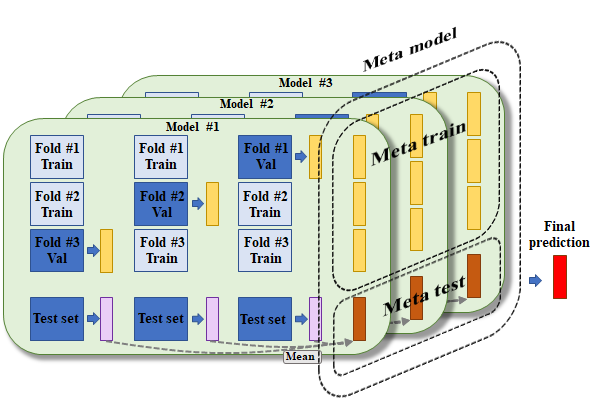

In [20]:
from sklearn.model_selection import KFold

def get_stacked_data(model, X_train, y_train, X_test, n_folds):
    kfold = KFold(n_splits=n_folds)
    
    # 결과값을 저장할 곳을 미리 만들어둔다.
    train_fold_predict = np.zeros((X_train.shape[0], 7))
    
    test_predict = np.zeros((X_test.shape[0], 7))
    print(model.__class__.__name__, "ongoing...")
    
    for cnt, (train_index, valid_index) in tqdm_notebook(enumerate(kfold.split(X_train))):
        # 5개로 나눈 데이터 중 4개 부분(학습용)
        X_train_ = X_train.iloc[train_index,1:]
        y_train_ = y_train[train_index]
        
        # 5개로 나눈 데이터 중 나머지 1개 부분(테스트용)
        X_validation = X_train.iloc[valid_index, 1:]
        
        # validation set제외 training set으로 모델을 학습시킨다.
        model.fit(X_train_, y_train_)
        
        
        # 결과값 저장소에 validation_set에 대한 예측값 저장
        train_fold_predict[valid_index, :] = model.predict_proba(X_validation)
        
    # 전체 training set에 대해 모델 학습
    model.fit(X_train.iloc[:,1:], y_train)
        
    # 결과값 저장소에 test_set에 대한 예측값 저장
    test_predict[:,:7] = model.predict_proba(X_test.iloc[:,1:])
    
        
    # test_predict의 결과들을 평균을 내서 하나로 합친다.
    #test_predict_mean = np.mean(test_predict, axis=0)
    
    print(model.__class__.__name__, "completed!")
    return train_fold_predict, test_predict

In [21]:
dt_train, dt_test = get_stacked_data(dt_bst, X, y, x_test, 10)
rf_train, rf_test = get_stacked_data(rf_bst, X, y , x_test, 10)
lgb_train, lgb_test = get_stacked_data(lgb_bst, X, y, x_test, 10)

DecisionTreeClassifier ongoing...


C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



DecisionTreeClassifier completed!
RandomForestClassifier ongoing...


C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



RandomForestClassifier completed!
LGBMClassifier ongoing...


C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



LGBMClassifier completed!


In [22]:
## 결과값들을 새로운 데이터로 형성 

new_X_train = np.concatenate((dt_train, rf_train, lgb_train), axis=1)
new_X_test = np.concatenate((dt_test, rf_test, lgb_test), axis=1)

In [23]:
lr = LogisticRegression()
lr.fit(new_X_train, y)
stacked_pred = lr.predict(new_X_test)

print("accuracy: {0:.4f}".format(accuracy_score(stacked_pred, y_test)))

accuracy: 0.8727


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# StackingCVClassifier의 사용(실전용)

In [24]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import StackingClassifier

In [25]:
stack_clf = StackingClassifier(classifiers=(dt_bst, rf_bst, lgb_bst),
                                 use_probas=True,
                                meta_classifier=lr)

stack_clf.fit(X.iloc[:,1:],y)
stack_clf_pred = stack_clf.predict(x_test.iloc[:,1:])
print("accuracy: {0:.4f}".format(accuracy_score(stack_clf_pred, y_test)))

accuracy: 0.8704


In [26]:
stackcv_clf = StackingCVClassifier(classifiers=(dt_bst, rf_bst, lgb_bst),
                                 use_probas=True,
                                meta_classifier=lr, random_state=10)

stackcv_clf.fit(X.iloc[:,1:],y)
stackcv_clf_pred = stackcv_clf.predict(x_test.iloc[:,1:])
print("accuracy: {0:.4f}".format(accuracy_score(stackcv_clf_pred, y_test)))

C:\Users\asus\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy: 0.8710
